In [0]:
import cv2
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.grid'] = False

In [0]:
def isValid(x, y, r, c):
    if(x>=0 and x<r and y>=0 and y<c):
        return 1
    else:
        return 0

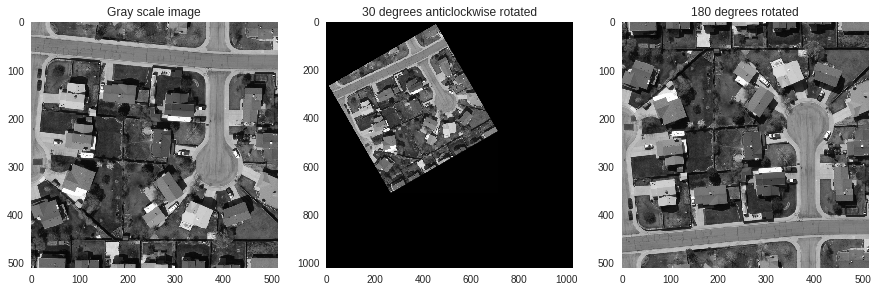

In [0]:
'''
Convert scale.png to grayscale and rotate by 30 and 180 degrees
'''

def rotate_by_180(image):
    r = len(image)
    c = len(image[0])
    new_image = np.zeros((r,c), np.uint8)
    
    for i in range(r):
        for j in range(c):
            new_image[i][j] = image[r-1-i][j]    
    return new_image


def rotate_by_30(image):
    r = len(image)
    c = len(image[0])
    new_image = np.zeros((2*r, 2*c), np.uint8)
    
    for i in range(2*r):
        for j in range(2*c):
            new_image[i][j] = 1

    a = math.cos(math.radians(30))
    b = math.sin(math.radians(30))

    for i in range(r):
        for j in range(c):
            x = ((i-r//2)*a) - ((j-c//2)*b)
            y = ((i-r//2)*b) + ((j-c//2)*a)
            
            x += r//math.sqrt(2)
            y += c//math.sqrt(2)
            
            x = abs(int(round(x)))
            y = abs(int(round(y)))
            
            if(isValid(x, y, 2*r, 2*c)):
                new_image[x][y] = image[i][j]
    return new_image

def alias(image30):
    r = len(image30)
    c = len(image30[0])

    for i in range(r):
        for j in range(c):
            #if pixel is a hole(same intensity as background)
            if(image30[i][j] == 1):
                temp = 0
                #taking values from valid 4 neighbours and taking mean
                if(isValid(i-1, j, r, c)):
                    temp += image30[i-1][j]
                if(isValid(i+1, j, r, c)):
                    temp += image30[i+1][j]
                if(isValid(i, j-1, r, c)):
                    temp += image30[i][j-1]
                if(isValid(i, j+1, r, c)):
                    temp += image30[i][j+1]
                
                image30[i][j] = temp//4
    return image30


image = cv2.imread('scale.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.subplot(1, 3, 1)
plt.title("Gray scale image")
plt.imshow(gray, cmap = "gray")

gray30 = rotate_by_30(gray)
gray30 = alias(gray30)
plt.subplot(1, 3, 2)
plt.title("30 degrees anticlockwise rotated")
plt.imshow(gray30, cmap = "gray")

gray180 = rotate_by_180(gray)
plt.subplot(1, 3, 3)
plt.title("180 degrees rotated")
plt.imshow(gray180, cmap = "gray")

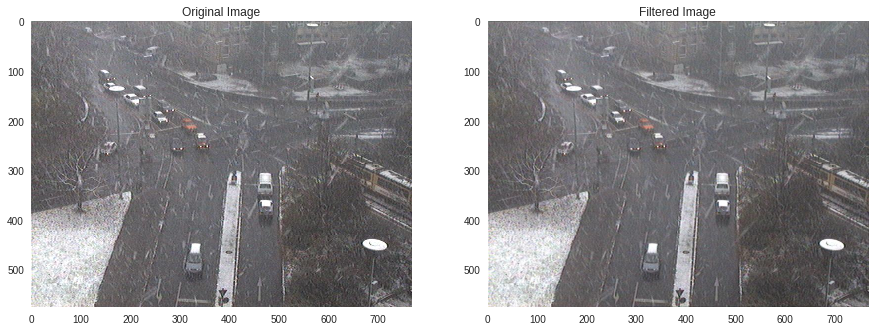

In [0]:
'''
Apply weighted mean filter on filter.jpg
'''

def apply_filter(img):
    r, c, channel = img.shape
    
    new_img = np.zeros(img.shape, np.uint8)

    for i in range(r):
        for j in range(c):
            t = [0,0,0]
            t[0] += img[i][j][0] * 4
            t[1] += img[i][j][1] * 4
            t[2] += img[i][j][2] * 4
            
            for p, q in [(i-1, j), (i, j-1), (i+1, j), (i, j+1)]:
                if(isValid(p, q, r, c)):
                    t[0] += img[p][q][0]
                    t[1] += img[p][q][1]
                    t[2] += img[p][q][2]
            
            new_img[i][j][0] = t[0]//8
            new_img[i][j][1] = t[1]//8
            new_img[i][j][2] = t[2]//8
    
    return new_img


image = cv2.imread('filter.jpg')
new_image = apply_filter(image)

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Filtered Image")
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))


Input image shape : (512, 512, 3)
Scaled image shape : (717, 717, 3)


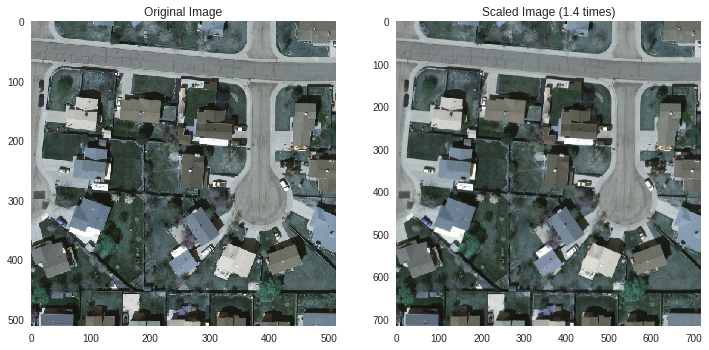

In [0]:
'''
Scale 'scale.png' to 1.4 times (use bilinear interpolation)
'''

def bilinear_interpolation(img, x, y):
    r, c, channels = img.shape
    #finding neighbours of the pixel to be calculated
    left_x = math.floor(x)
    left_y = math.floor(y)
    right_x = left_x+1
    right_y = left_y+1
    
    #if right neighbour is out of boundary then make it as pixel at the boundary
    if(right_x >= r):
        right_x -= 1
    if(right_y >= c):
        right_y -= 1
    
    pixel_value = []
    
    for c in range(channels):
        #2 interpolations in x direction and final interpolation in y direction
        ipx1 = ((right_y - y) * img[left_x][left_y][c]) + ((y - left_y) * img[left_x][right_y][c])
        ipx2 = ((right_y - y) * img[right_x][left_y][c]) + ((y - left_y) * img[right_x][right_y][c])
        
        ipy1 = ((right_x - x) * ipx1) + ((x - left_x) * ipx2)
        pixel_value.append(int(round(ipy1)))

    return pixel_value


def scale_image(img, factor):
    r, c , channels = img.shape
    
    r_scale = math.ceil(r*factor)
    c_scale = math.ceil(c*factor)

    new_img = np.zeros((r_scale, c_scale, 3), np.uint8)

    for i in range(r_scale):
        for j in range(c_scale):
            #finding pixel from original image corresponding to (i,j) pixel in new image
            x = i/factor
            y = j/factor
            new_img[i][j] = bilinear_interpolation(img, x, y)
    return new_img


img = cv2.imread('scale.png')
new_img = scale_image(img, 1.4)

print("Input image shape :", img.shape)
print("Scaled image shape :", new_img.shape)

plt.figure(figsize = (12, 12))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Scaled Image (1.4 times)")
plt.imshow(new_img)

Scale factor : 1.69921875
Input image shape : (512, 512, 3)
Scaled image shape : (870, 870, 3)


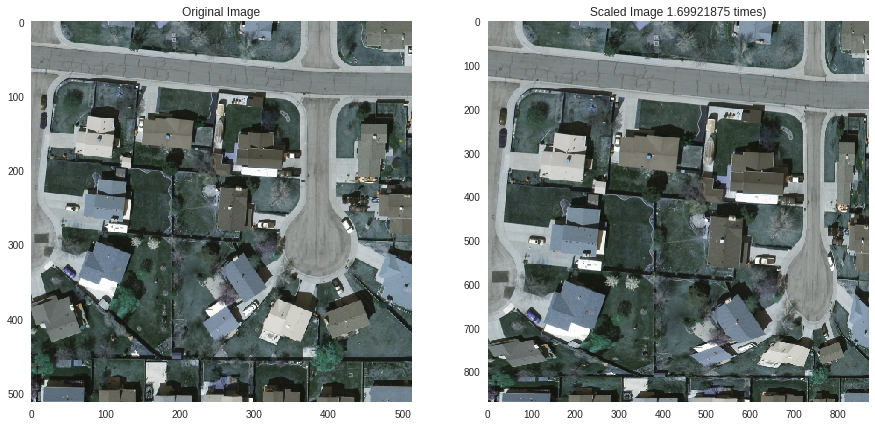

In [0]:
'''
Find  scaling factor and perform nearest neighbour interpolation on ‘scale.png’
'''

def scale_image(img, factor):
    r, c, channels = img.shape
    
    r2 = math.ceil(r * factor)
    c2 = math.ceil(c * factor)
    
    #print(r, c, r2, c2)
    
    new_img = np.zeros((r2, c2, channels), np.uint8)

    for i in range(r2):
        for j in range(c2):
            for ch in range(channels):
                new_img[i][j][ch] = 2
                
    #putting correct pixel values in output image as per the scaling factor
    #first phase
    i=0; x=0
    while(x < r2-r):
        j=0; y=0
        
        while(y < c2-c):
            new_img[i][j][0] = img[x][y][0]
            new_img[i][j][1] = img[x][y][1]
            new_img[i][j][2] = img[x][y][2]
            '''
            as per the scaling factor in this case(870/512)
            each pixel needs to set its 3 neighbours
            1st neighbour => right to it
            2nd neighbour => below it
            3rd neighbour => diagonally down 
            whichever neighbour is valid , it is set appropriately
            '''
            for p, q in [(i, j+1), (i+1, j), (i+1, j+1)]:
                if(isValid(p, q, r2, c2)):
                    new_img[p][q][0] = img[x][y][0]
                    new_img[p][q][1] = img[x][y][1]
                    new_img[p][q][2] = img[x][y][2]
            
            j += math.ceil(factor)
            y += 1
        
        i += math.ceil(factor)
        x += 1
    
    #2nd phase
    i=0; x=0
    while(i < (r2-r)*2 and x < r):
        j = (c2-c)*2
        y = c2-c
        
        while(j < c2 and y < c):
            new_img[i][j][0] = img[x][y][0]
            new_img[i][j][1] = img[x][y][1]
            new_img[i][j][2] = img[x][y][2]
            
            if(isValid(i+1, j, r2, c2)):
                new_img[i+1][j][0] = img[x][y][0]
                new_img[i+1][j][1] = img[x][y][1]
                new_img[i+1][j][2] = img[x][y][2]
            j += 1
            y += 1
        i += math.ceil(factor)
        x += 1
    
    #3rd phase
    i = (r2-r)*2
    x = r2-r
    while(i<r2 and x<r):
        j=0; y=0
        
        while(j < (c2-c)*2 and y<c):
            new_img[i][j][0] = img[x][y][0]
            new_img[i][j][1] = img[x][y][1]
            new_img[i][j][2] = img[x][y][2]
            
            if(isvalid(i, j+1, r2, c2)):
                new_img[i][j+1][0] = img[x][y][0]
                new_img[i][j+1][1] = img[x][y][1]
                new_img[i][j+1][2] = img[x][y][2]
            j += math.ceil(factor)
            y += 1
            
        i += 1
        x += 1
    
    #4th phase
    i = (r2-r)*2
    x = r2-r
    while(i < r2 and x < r):
        j = (c2-c)*2
        y = c2-c
        
        while(j < c2 and y < c):
            new_img[i][j][0] = img[x][y][0]
            new_img[i][j][1] = img[x][y][1]
            new_img[i][j][2] = img[x][y][2]
            j += 1
            y += 1
            
        i += 1
        x += 1

    return new_img


img = cv2.imread('scale.png')
scale_factor = 870/512
print("Scale factor :", scale_factor)
new_img = scale_image(img, scale_factor)

print("Input image shape :", img.shape)
print("Scaled image shape :", new_img.shape)

#plt.figure(figsize = (12, 12))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Scaled Image " + str(scale_factor) + " times)")
plt.imshow(new_img)

(576, 768, 3)


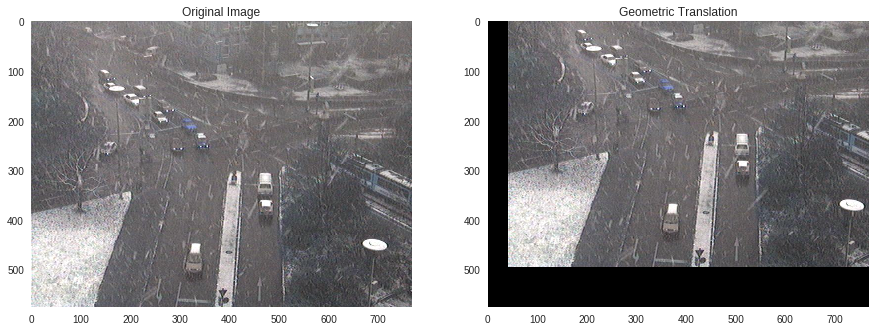

In [0]:
img = cv2.imread("filter.jpg")

d_x = 40
d_y = -80

print(img.shape)
new_img = np.zeros(img.shape, np.uint8)

r, c, channels = img.shape

for i in range(r):
    for j in range(c):
        for k in range(channels):
            if(isValid(i + d_y, j + d_x, r, c)):
                new_img[i + d_y][j + d_x][k] = img[i][j][k]

plt.subplot(121)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(122)
plt.title("Geometric Translation")
plt.imshow(new_img)

Sigma = 1.4
Low threshold = 20
High threshold = 45


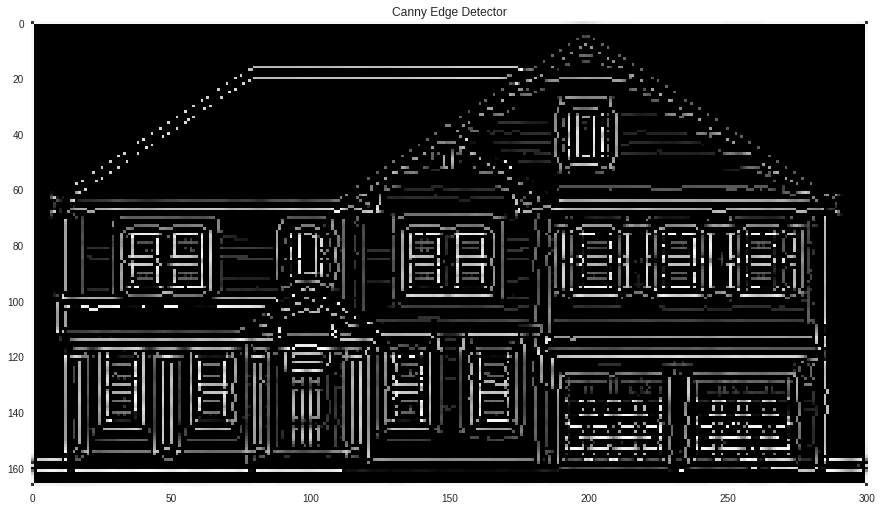

In [0]:
'''
Canny edge detection technique
'''

sys.setrecursionlimit(1000*1000*4)

def apply_filter(kernel, r, c, img):
    value = 0
    k_r, k_c = len(kernel), len(kernel[0])
    i_r, i_c = img.shape
    
    for i in range(k_r):
        for j in range(k_c):
            x = i + r - (k_r//2)
            y = j + c - (k_c//2)

            if(isValid(x, y, i_r, i_c)):
                value += (kernel[i][j] * img[x][y])
    return value


def dfs_visit(suppressed, r, c, visited, i, j):
    if(visited[i][j] == 1):
        return

    if(suppressed[i][j] < th_low):
        visited[i][j] = 1
        return
    
    visited[i][j] = 1

    for p, q in [(i-1, j-1), (i-1, j), (i-1, j+1), (i, j-1), (i, j+1), (i+1, j-1), (i+1, j), (i+1, j+1)]: 
        if(isValid(p, q, r, c)):
            dfs_visit(suppressed, r, c, visited, p, q)
        
    return


sigma = 1.4
img = cv2.imread('house.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#im = gaussian_blur(im, sigma)
img = cv2.GaussianBlur(img, (5, 5), 1.4)

#sobel filters for gradients in x and y directions
filter_x = [[-1,0,1], [-2,0,2], [-1,0,1]]
filter_y = [[-1,-2,-1], [0,0,0], [1,2,1]]

r, c = img.shape

grad_x = np.zeros(img.shape, np.float)
grad_y = np.zeros(img.shape, np.float)

grad_magnitude = np.zeros(img.shape, np.float)
grad_angle = np.zeros(img.shape, np.float)

for i in range(r):
    for j in range(c):
        grad_x[i][j] = apply_filter(filter_x, i, j, img)
        grad_y[i][j] = apply_filter(filter_y, i, j, img)
        
        x, y = grad_x[i][j], grad_y[i][j]
        
        grad_magnitude[i][j] = math.sqrt((x ** 2) + (y ** 2))
        
        t = round(math.degrees(math.atan2(y,x)), 3)
        if(t < 0):
            t += 180
        
        grad_angle[i][j] = t
        

suppressed = np.copy(grad_magnitude)
th_low= 20
th_high= 45

for i in range(r):
    for j in range(c):
        angle = gradient_angle[i][j]
        pixel1 = 0
        pixel2 = 0

        if((angle>=0 and angle<=22.5) or (angle>157.5 and angle<=180)):
            if(j-1>=0):
                pixel1 = grad_magnitude[i][j-1]
            if(j+1<c):
                pixel2 = grad_magnitude[i][j+1]
        
        elif(angle>22.5 and angle<=67.5):
            if(j-1>=0 and i+1<r):
                pixel1 = grad_magnitude[i+1][j-1]
            if(j+1<c and i-1>=0):
                pixel2 = grad_magnitude[i-1][j+1]
        
        elif(angle>67.5 and angle<=112.5):
            if(i-1>=0):
                pixel1 = grad_magnitude[i-1][j]
            if(i+1<r):
                pixel2 = grad_magnitude[i+1][j]
        
        elif(angle>112.5 and angle<=157.5):
            if(i-1>=0 and j-1>=0):
                pixel1 = grad_magnitude[i-1][j-1]
            if(i+1<r and j+1<c):
                pixel2 = grad_magnitude[i+1][j+1]
        
        if(grad_magnitude[i][j] < pixel1 or grad_magnitude[i][j] < pixel2):
            suppressed[i][j] = 0

plt.imshow(suppressed.astype(np.uint8), cmap = "gray")

visited = np.zeros_like(suppressed)
for i in range(r):
    for j in range(c):
        if(suppressed[i][j] > th_high and visited[i][j] == 0):
            dfs_visit(suppressed, r, c, visited, i, j)
            
#pixels which have not been visited represent weak edges , so set them to 0
for i in range(r):
    for j in range(c):
        if(visited[i][j] == 0):
            suppressed[i][j] = 0

print("Sigma =", sigma)
print("Low threshold =", th_low)
print("High threshold =", th_high)

plt.title('Canny Edge Detector')
plt.imshow(suppressed.astype(np.uint8), cmap = "gray")

Number of zero crossings for kernel  1  and sigma =  1  are  8097
Number of zero crossings for kernel  1  and sigma =  2  are  19803
Number of zero crossings for kernel  1  and sigma =  3  are  15012


Number of zero crossings for kernel  2  and sigma =  1  are  16403
Number of zero crossings for kernel  2  and sigma =  2  are  3727
Number of zero crossings for kernel  2  and sigma =  3  are  1176




'\nobservations:\n    kernel 1 gives better result for sigma = 2,3\n    kernel 2 gives better result for sigma = 1\n    for all three sigma values , results of kernel 1 are better than kernel 2\n    as we increase sigma value , number of zero crossings first increase and then decrease for given laplace kernels\n'

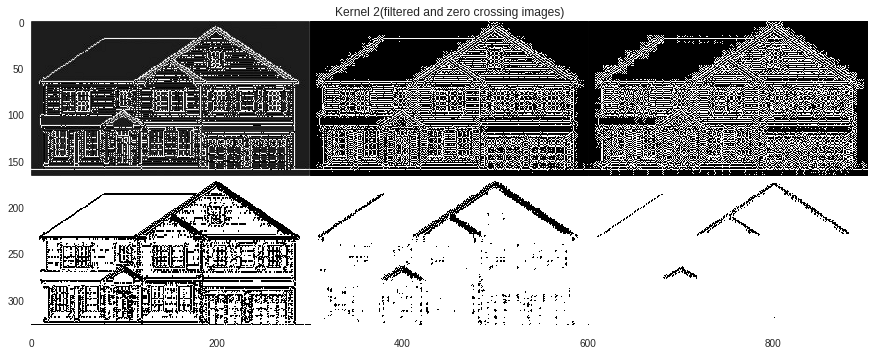

In [0]:
'''
Laplacian of Gaussian edge detection technique
'''

#function to find value of gaussian kernel for given (x,y) and given sigma value
def calculate_gauss(x,y,sigma):
    val = (x**2)+(y**2)
    val*=-1
    val/=2
    val/=(sigma**2)
    val1 = math.exp(val)
    val1/=2
    val1/=math.pi
    val1/=(sigma**2)
    return val1
    
#function to apply convolution operation
def apply_filter(laplace_kernel,kernel_size_x,kernel_size_y,r,c,gaussian_filter,filter_size_x,filter_size_y):
    value=0
    #for each pixel of filter
    for i in range(kernel_size_x):
        for j in range(kernel_size_y):
            #coordinates of image pixel as per standard coordinate system
            x=i+r-(kernel_size_x//2)
            y=j+c-(kernel_size_y//2)
            #if coordinates are valid then apply operation (assuming padding of 0)
            if(isValid(x,y,filter_size_x,filter_size_y)):
                value+=(laplace_kernel[i][j]*gaussian_filter[x][y])
    return value
    
#function to get log filter
def get_filter(laplace_kernel,size,sigma):
    #new matrix for filter
    mat=[]
    #for each value in output filter
    for i in range(size):
        mat.append([])
        for j in range(size):
            #find coordinates of the cell as per standard coordinate system
            x=j-(size//2)
            y=(size//2)-i
            mat[i].append(round(laplace_kernel[i][j]*calculate_gauss(x,y,sigma),5))
    #returning the output filter
    return mat
    
#function to convert a matrix into numpy matrix
def get_numpy(im):
    im2=np.zeros((len(im),len(im[0])),np.uint8)
    for i in range(len(im)):
        for j in range(len(im[0])):
            im2[i][j]=im[i][j]
    return im2
    
#function to check if zero crossing slope is in threshold(positive) or not
def above_threshold(a,b):
    global threshold
    if(abs(a-b) > threshold):
        return 1
    else:
        return 0


img = cv2.imread('house.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

laplace_kernel1 = [[1,1,1], [1,-8,1], [1,1,1]]
laplace_kernel2 = [[-1,2,-1], [2,-4,2], [-1,2,-1]]

laplace_kernels = [laplace_kernel1, laplace_kernel2]

gaussian_filter_size = 5
threshold = 15
sigmas = [1, 2, 3]

c = 0

for laplace_kernel in laplace_kernels:
    filtered_images = []
    crossing_images = []
    
    c+=1
    s=0
    
    for sigma in sigmas:
        s+=1

        log = get_filter(laplace_kernel, 3, sigma)

        im2 = []
        
        #for each pixel in image apply the filter
        for i in range(len(gray)):
            im2.append([])
            for j in range(len(gray[i])):
                im2[i].append(math.floor(apply_filter(log,len(log),len(log[0]),i,j,gray,len(gray),len(gray[0]))))
        
        #matrix for zero crossings
        crossing = np.zeros((len(im2),len(im2[0])),np.uint8)
        i=0
        #counting total number of zero crossings found
        count=0
        
        #for each pixel
        while(i<len(im2)):
            j=0
            
            while(j<len(im2[i])):
                if(im2[i][j]==0):
                    if(j-1>=0 and j+1<len(im2[i]) and im2[i][j-1]<0 and im2[i][j+1]>0 and above_threshold(im2[i][j-1],im2[i][j+1])):
                        crossing[i][j]=255
                        count+=1
                    if(j-1>=0 and j+1<len(im2[i]) and im2[i][j-1]>0 and im2[i][j+1]<0 and above_threshold(im2[i][j-1],im2[i][j+1])):
                        crossing[i][j]=255
                        count+=1
                    if(i-1>=0 and i+1<len(im2) and im2[i-1][j]<0 and im2[i+1][j]>0 and above_threshold(im2[i-1][j],im2[i+1][j])):
                        crossing[i][j]=255
                        count+=1
                    if(i-1>=0 and i+1<len(im2) and im2[i-1][j]>0 and im2[i+1][j]<0 and above_threshold(im2[i-1][j],im2[i+1][j])):
                        crossing[i][j]=255
                        count+=1
                else:
                    if(j-1>=0 and j+1<len(im2[i]) and im2[i][j-1]<0 and im2[i][j]>0 and above_threshold(im2[i][j-1],im2[i][j])):
                        crossing[i][j]=255
                        count+=1
                    if(j-1>=0 and j+1<len(im2[i]) and im2[i][j-1]>0 and im2[i][j]<0 and above_threshold(im2[i][j-1],im2[i][j])):
                        crossing[i][j]=255
                        count+=1
                    if(i-1>=0 and i+1<len(im2) and im2[i-1][j]<0 and im2[i][j]>0 and above_threshold(im2[i-1][j],im2[i][j])):
                        crossing[i][j]=255
                        count+=1
                    if(i-1>=0 and i+1<len(im2) and im2[i-1][j]>0 and im2[i][j]<0 and above_threshold(im2[i-1][j],im2[i][j])):
                        crossing[i][j]=255
                        count+=1
                j+=1
            i+=1

        print("Number of zero crossings for kernel ",c," and sigma = ",s," are ",count)
        filtered_images.append(get_numpy(im2))
        crossing_images.append(crossing)
    
    val1 = np.concatenate((filtered_images[0],filtered_images[1],filtered_images[2]),axis=1) 
    val2 = np.concatenate((crossing_images[0],crossing_images[1],crossing_images[2]),axis=1) 
    val3 = np.concatenate((val1,val2),axis=0) 
    
    plt.title("Kernel " + str(c) + "(filtered and zero crossing images)")
    plt.imshow(val3)
    print()
    print()
    
'''
observations:
    kernel 1 gives better result for sigma = 2,3
    kernel 2 gives better result for sigma = 1
    for all three sigma values , results of kernel 1 are better than kernel 2
    as we increase sigma value , number of zero crossings first increase and then decrease for given laplace kernels
'''


## Gaussian Blur

In [0]:
def get_gaussian_kernel(size, sigma):
    res = []
    for i in range(size):
        res.append([])
        for j in range(size):
            x = j - (size//2)
            y = (size//2) - i
            
            val = (x**2)+(y**2)
            val*=-1
            val/=2
            val/=(sigma**2)
            val1 = math.exp(val)
            val1/=2
            val1/=math.pi
            val1/=(sigma**2)
            
            res[i].append(round(val1, 4))
    return res

        
def apply_filter(kernel, r, c, img):
    value = 0
    k_r, k_c = len(kernel), len(kernel[0])
    i_r, i_c = img.shape
    
    for i in range(k_r):
        for j in range(k_c):
            x = i + r - (k_r//2)
            y = j + c - (k_c//2)

            if(isValid(x, y, i_r, i_c)):
                value += (kernel[i][j] * img[x][y])
    return value


def gaussian_blur(img, sigma):
    kernel = get_gaussian_kernel(5, sigma)
    
    blur_image = np.zeros(img.shape, np.uint8)
    r, c = img.shape
    
    for i in range(r):
        for j in range(c):
            blur_image[i][j] = round(apply_filter(kernel, i, j, img), 4)
    
    return blur_image